### External imports

In [1]:
# imports
import numpy as np
from numpy.lib.stride_tricks import as_strided
import cupy as cp
from scipy import signal, misc

import math
import time
import importlib

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


### Internal Imports

In [2]:
import plot_utility as pu

### Create - Data, Consts, Pars, Lower Bound, Upper Bound

In [3]:
nparam = 4

slice_start = 25
slice_stop = 26

# Data
data = None
with open('data_ivim.npy', 'rb') as f:
    data = np.load(f)[:,:,slice_start:slice_stop,:]
nvoxels = data.shape[0] * data.shape[1] * data.shape[2]
ndata = data.shape[3]
#data_flat = data.flatten().reshape((1, ndata*nvoxels), order='C')
data_flat = np.tile(np.reshape(np.array([908.02686, 905.39154, 906.08997, 700.7829, 753.0848, 859.9136,
 	   870.48846, 755.96893, 617.3499, 566.2044 , 746.62067, 662.47424,
 	   628.8806, 459.7746 , 643.30554, 318.58453, 416.5493, 348.34335,
 	   411.74026, 284.17468, 290.30487], dtype=np.float32), (1,21)), (1,nvoxels))

# Consts
consts = None
with open('bvals_ivim.npy', 'rb') as f:
    consts = np.load(f).astype(cp.float32)
consts = np.reshape(consts, (1,21))
consts_flat = np.tile(consts, (1, nvoxels))

# Pars
pars_dipy = None
with open('pars_ivim_dipytrr.npy', 'rb') as f:
    pars_dipy = np.load(f)[:,:,slice_start:slice_stop,:]
#pars_flat = np.transpose(pars_dipy, (3,0,1,2)).reshape((nparam,nvoxels),order='C')
pars_flat = np.empty((nparam, nvoxels), dtype=np.float32)
pars_flat[0,:] = 10000 #pars_dipy[:,:,:,0].flatten()
pars_flat[1,:] = 0.5 #pars_dipy[:,:,:,1].flatten()
pars_flat[2,:] = 0.01 #pars_dipy[:,:,:,2].flatten()
pars_flat[3,:] = 0.001 #pars_dipy[:,:,:,3].flatten()

lower_bound = cp.empty((nparam, nvoxels), dtype=np.float32)
lower_bound[0,:] = np.finfo(np.float32).min
lower_bound[1,:] = 0.0
lower_bound[2,:] = 0.0
lower_bound[3,:] = 0.0

upper_bound = cp.empty((nparam, nvoxels), dtype=np.float32)
upper_bound[0,:] = np.finfo(np.float32).max / 2
upper_bound[1,:] = 1.0
upper_bound[2,:] = 0.5
upper_bound[3,:] = 0.1

In [4]:
import cuda.lsqnonlin as clsq
importlib.reload(clsq)

expr = 'S0*(f*exp(-b*D_1)+(1-f)*exp(-b*D_2))'
pars_str = ['S0', 'f', 'D_1', 'D_2']
consts_str = ['b']

nchunks = 1
chunk_size = math.ceil(nvoxels / nchunks)

first_f = np.empty((1, nvoxels), dtype=np.float32)
last_f = np.empty((1, nvoxels), dtype=np.float32)

solm = clsq.SecondOrderLevenbergMarquardt(expr, pars_str, consts_str, ndata=ndata, dtype=cp.float32, write_to_file=True)

start = time.time()

parscu = cp.array(pars_flat, dtype=cp.float32, copy=True, order='C')
constscu = cp.array(consts_flat, dtype=cp.float32, copy=True, order='C')
datacu = cp.array(data_flat, dtype=cp.float32, copy=True, order='C')
lower_bound_cu = cp.array(lower_bound, dtype=cp.float32, copy=True, order='C')
upper_bound_cu = cp.array(upper_bound, dtype=cp.float32, copy=True, order='C')

solm.setup(parscu, constscu, datacu, lower_bound_cu, upper_bound_cu)
parscu = solm.run(100, 1e-30)

first_f = solm.first_f.get()
last_f = solm.last_f.get()

pars_flat = parscu.get()

# for i in range(0,nchunks):

# 	ptemp = pars_flat[:,i*chunk_size:(i+1)*chunk_size].copy(order='C')
# 	ctemp = consts_flat[:,i*chunk_size*ndata:(i+1)*chunk_size*ndata].copy(order='C')
# 	dtemp = data_flat[:,i*chunk_size*ndata:(i+1)*chunk_size*ndata].copy(order='C')
# 	ltemp = lower_bound[:,i*chunk_size:(i+1)*chunk_size].copy(order='C')
# 	utemp = upper_bound[:,i*chunk_size:(i+1)*chunk_size].copy(order='C')

# 	parscu = cp.array(ptemp, dtype=cp.float32, copy=True, order='C')
# 	constscu = cp.array(ctemp, dtype=cp.float32, copy=True, order='C')
# 	datacu = cp.array(dtemp, dtype=cp.float32, copy=True, order='C')
# 	lower_bound_cu = cp.array(ltemp, dtype=cp.float32, copy=True, order='C')
# 	upper_bound_cu = cp.array(utemp, dtype=cp.float32, copy=True, order='C')

# 	solm.setup(parscu, constscu, datacu, lower_bound_cu, upper_bound_cu)
# 	parscu = solm.run(50, 1e-30)

# 	first_f[:,i*chunk_size:(i+1)*chunk_size] = solm.first_f.get()
# 	last_f[:,i*chunk_size:(i+1)*chunk_size] = solm.last_f.get()

# 	pars_flat[:,i*chunk_size:(i+1)*chunk_size] = parscu.get()

end = time.time()
print('It took: ' + str(end - start) + ' s')



It took: 1134.6180684566498 s


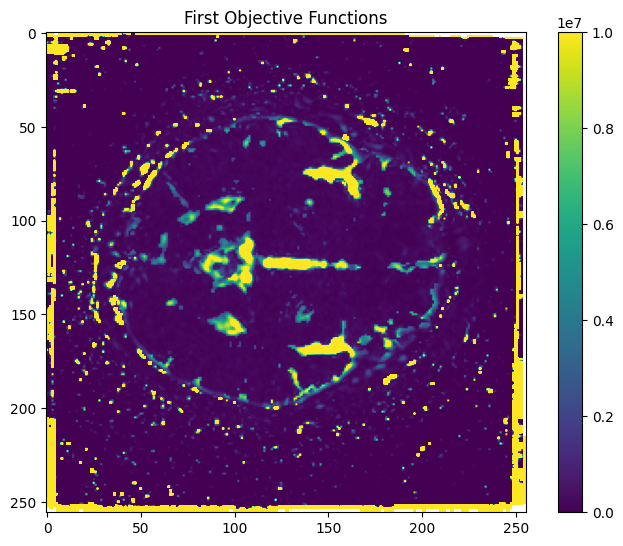

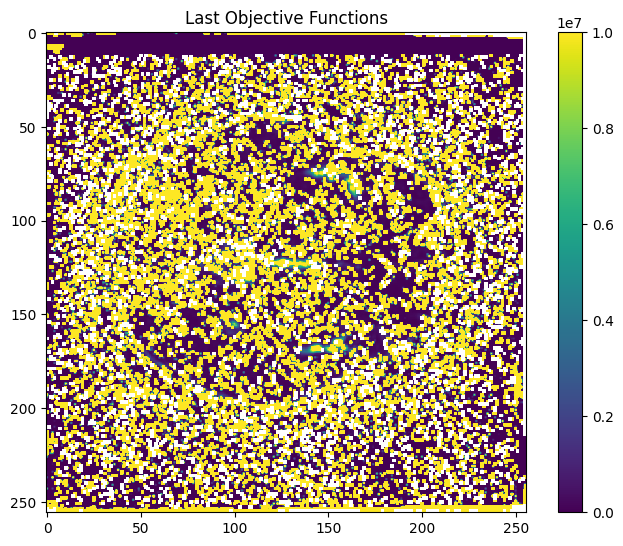

In [5]:
ffig1 = plt.figure()
fax1 = ffig1.add_axes([0,0,1,1])
ffigdata1 = fax1.imshow(np.reshape(first_f, (data.shape[0], data.shape[1], data.shape[2]))[:,:,0])
fax1.set_title('First Objective Functions')
ffigdata1.set_clim(0.0, 1e7)
ffig1.colorbar(ffigdata1, ax=fax1)

ffig2 = plt.figure()
fax2 = ffig2.add_axes([0,0,1,1])
ffigdata2 = fax2.imshow(np.reshape(last_f, (data.shape[0], data.shape[1], data.shape[2]))[:,:,0])
fax2.set_title('Last Objective Functions')
ffigdata2.set_clim(0.0, 1e7)
ffig2.colorbar(ffigdata2, ax=fax2)

In [12]:
pars_flat_back = np.transpose(np.reshape(pars_flat, (4, data.shape[0], data.shape[1], data.shape[2])), (1,2,3,0))


In [38]:
gemask = pars_flat_back[:,:,:,2] < pars_flat_back[:,:,:,3]

temp = pars_flat_back[gemask, 2].copy()
pars_flat_back[gemask, 2] = pars_flat_back[gemask, 3].copy()
pars_flat_back[gemask, 3] = temp.copy()
pars_flat_back[gemask, 1] = 1 - pars_flat_back[gemask, 1]


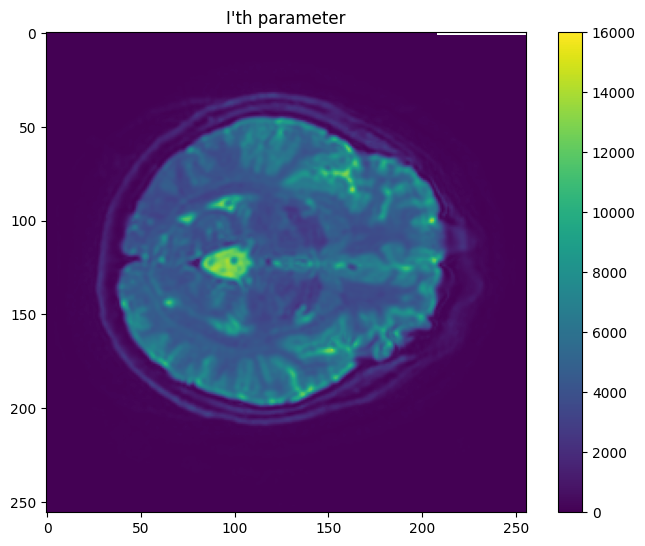

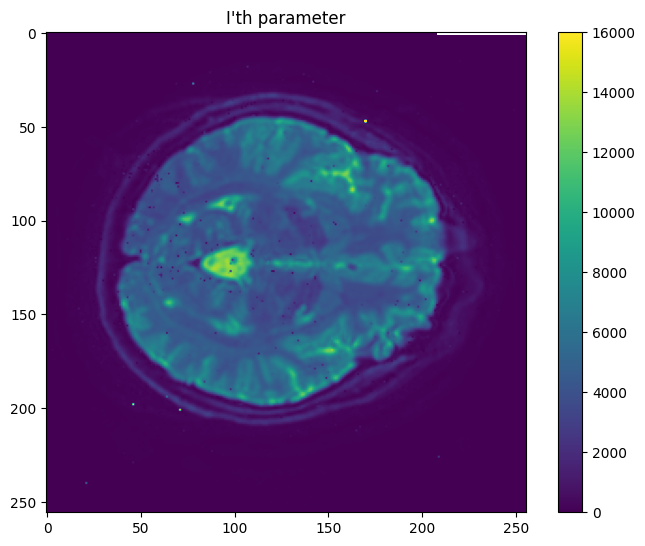

In [13]:
#param_printer(pars, print_S0=True)
pu.param_printer(pars_dipy, slicez=0, clim=[0.0, 16000], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[0])

pu.param_printer(pars_flat_back, slicez=0, clim=[0.0, 16000], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[0])


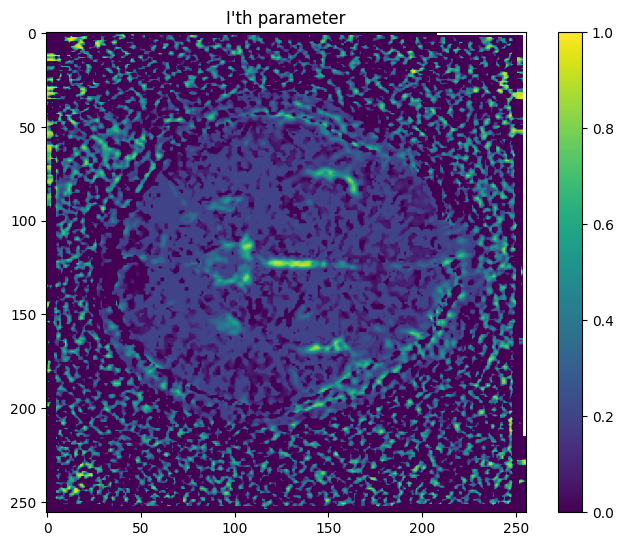

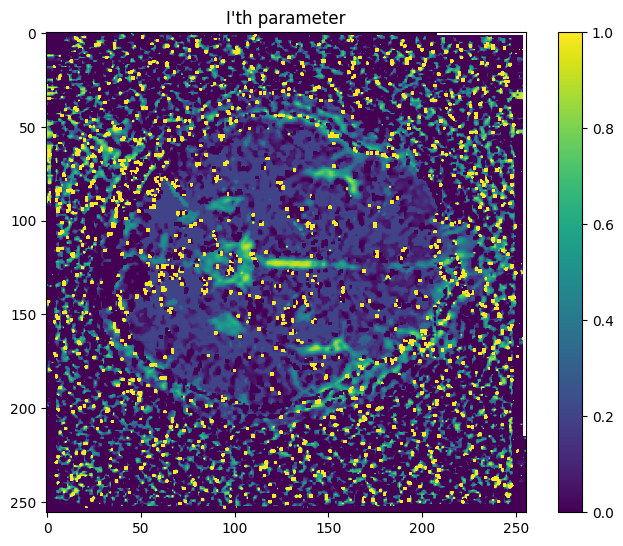

In [14]:
#param_printer(pars, print_S0=True)
pu.param_printer(pars_dipy, slicez=0, clim=[0.0, 1.0], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[1])

pu.param_printer(pars_flat_back, slicez=0, clim=[0.0, 1.0], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[1])


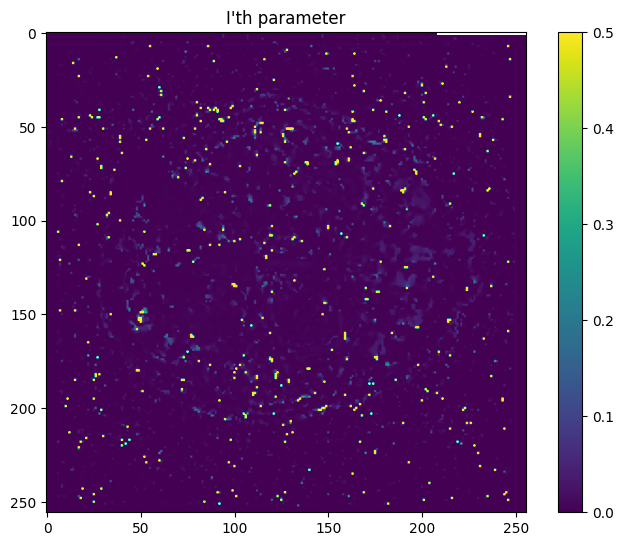

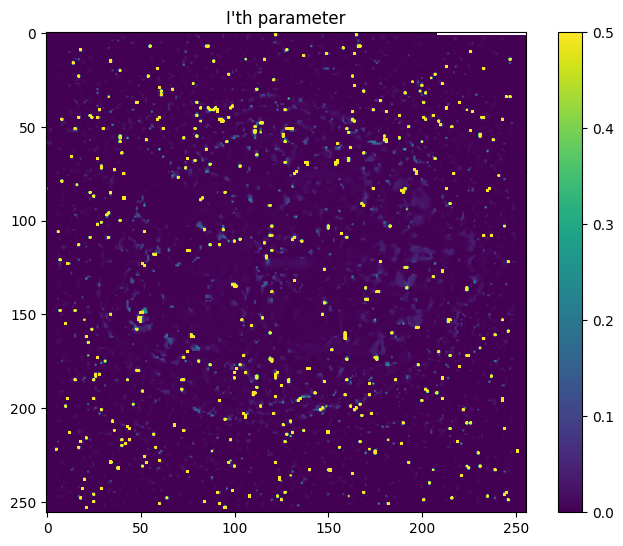

In [15]:
#param_printer(pars, print_S0=True)
pu.param_printer(pars_dipy, slicez=0, clim=[0.0, 0.5], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[2])

pu.param_printer(pars_flat_back, slicez=0, clim=[0.0, 0.5], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[2])


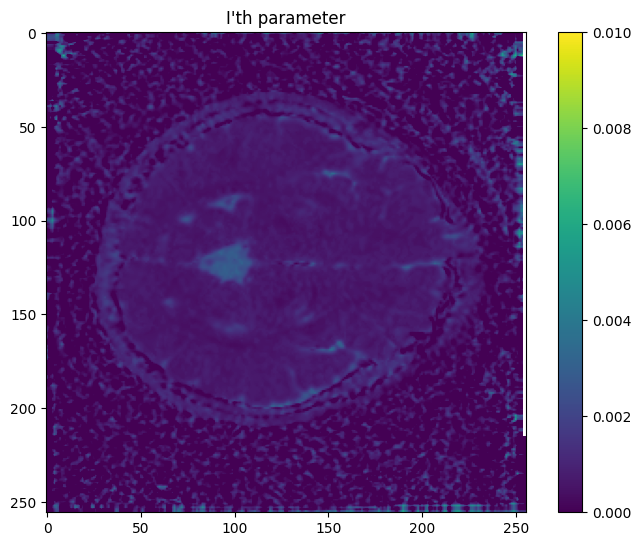

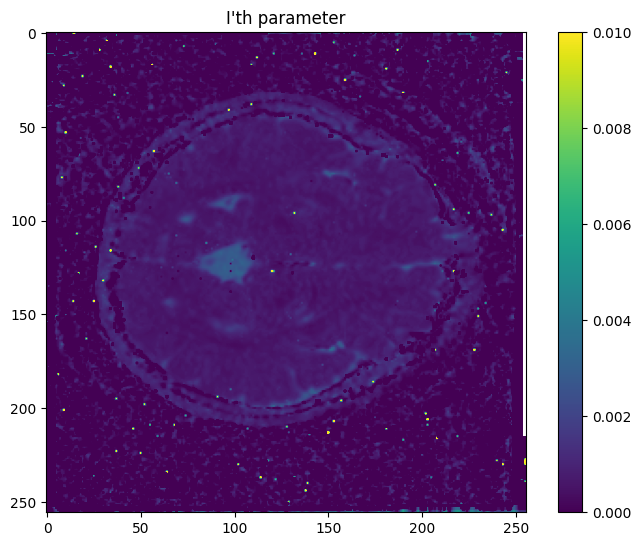

In [16]:
#param_printer(pars, print_S0=True)
pu.param_printer(pars_dipy, slicez=0, clim=[0.0, 0.01], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[3])

pu.param_printer(pars_flat_back, slicez=0, clim=[0.0, 0.01], viewport=[[0.0, 1.0],[0.0, 1.0]], pars_idx=[3])


[6.4367861e+03 4.9973926e-01 5.9896853e-02 6.4282876e-04]
[[5919.5522 3765.5544 3723.589  4294.937  3926.136  3538.5386 3238.848
  3789.8738 3516.3525 2972.3171 2926.5825 3174.6287 2939.2305 2608.0999
  2388.547  2158.8213 1930.1462 1869.5845 1766.0068 1728.042  1693.328 ]]


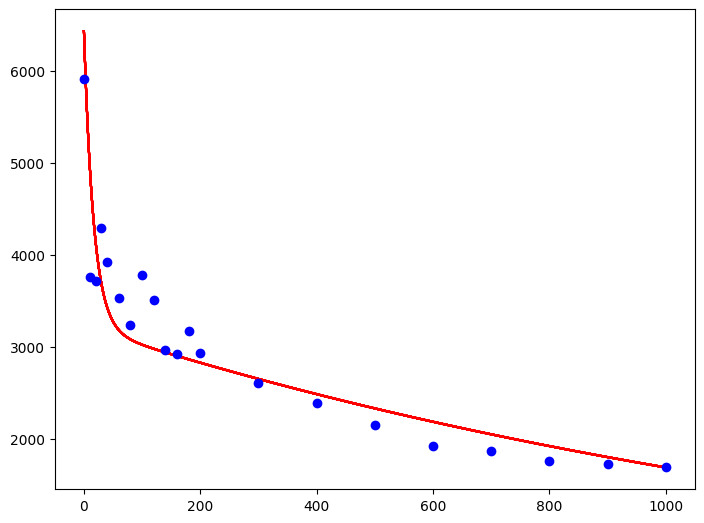

In [11]:
importlib.reload(pu)

pars_to_plot = pars_flat_back[120,120,0,:]
data_to_plot = np.reshape(data[120,120,0,:], (1,21))
print(pars_to_plot)
print(data_to_plot)

pu.plot_curve_fit(pu.ivim_curve_plot_expr(), pars_to_plot, consts, data_to_plot)

[4.3348662e+03 5.0780159e-01 1.2005565e-01 4.1708304e-04]
[[2438.5193 2502.314  2370.0117 2273.194  2463.1465 2350.9778 2359.6628
  2404.785  2419.0615 2254.745  2084.249  2346.267  2209.802  1998.6549
  1910.1864 1676.512  1636.8896 1438.7007 1356.5272 1315.237  1216.4425]]


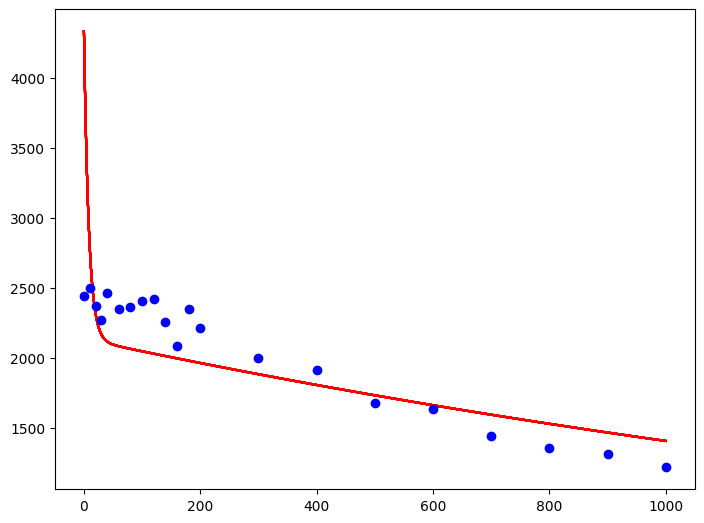

In [12]:
importlib.reload(pu)

pars_to_plot = pars_flat_back[140,140,0,:]
data_to_plot = np.reshape(data[140,140,0,:], (1,21))
print(pars_to_plot)
print(data_to_plot)

pu.plot_curve_fit(pu.ivim_curve_plot_expr(), pars_to_plot, consts, data_to_plot)